<a href="https://colab.research.google.com/github/ArjunaBazaz/Presidential_Approval_Rating_Prediction/blob/main/SCRIPTS/4_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install statsmodels
!pip install pmdarima
!pip install prophet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.



  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/02/4e/5ac0b5b9a239cd3fdae187dda8ff06b0b812f671e2501bf253712278f0ac/Cython-3.0.12-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   - ------------------------------------- 30.7/614.7 kB 435.7 kB/s eta 0:00:02
   --------- ------------------------------ 153.6/614.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------- ------------------------------- 0.6/2.8 MB 17.8 MB/s eta 0:00:01
   ------------- ----------

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import os
import glob

os.chdir('../DATA')
csv_files = glob.glob('*.csv')
print(csv_files)

['approval_rating.csv', 'approval_rating_biden_1.csv', 'approval_rating_biden_1_updated.csv', 'approval_rating_bushjr_1_2.csv', 'approval_rating_bushjr_1_2_updated.csv', 'approval_rating_bushsr_1.csv', 'approval_rating_bushsr_1_updated.csv', 'approval_rating_carter_1.csv', 'approval_rating_carter_1_updated.csv', 'approval_rating_clinton_1_2.csv', 'approval_rating_clinton_1_2_updated.csv', 'approval_rating_eisenhower_1_2.csv', 'approval_rating_eisenhower_1_2_updated.csv', 'approval_rating_ford_1.csv', 'approval_rating_ford_1_updated.csv', 'approval_rating_johnson_1_2.csv', 'approval_rating_johnson_1_2_updated.csv', 'approval_rating_kennedy_1.csv', 'approval_rating_kennedy_1_updated.csv', 'approval_rating_nixon_1_2.csv', 'approval_rating_nixon_1_2_updated.csv', 'approval_rating_obama_1_2.csv', 'approval_rating_obama_1_2_updated.csv', 'approval_rating_reagan_1_2.csv', 'approval_rating_reagan_1_2_updated.csv', 'approval_rating_roosevelt_3_4.csv', 'approval_rating_roosevelt_3_4_updated.csv'

Now we have imported the data we need from Github. Let's properly load our data and define a start and end date.

In [4]:
import pandas as pd

# -------------------------
# 1. Load Datasets and Parse Dates
# -------------------------

# Load the approval ratings dataset and convert dates (handle mixed formats)
approval_df = pd.read_csv('approval_rating.csv', parse_dates=['Start Date', 'End Date'])
approval_df['Start Date'] = pd.to_datetime(approval_df['Start Date'], errors='coerce')
approval_df['End Date'] = pd.to_datetime(approval_df['End Date'], errors='coerce')

# Load other datasets with their date columns
income_df = pd.read_csv('median_household_income_daily_change.csv', parse_dates=['observation_date'])
gdp_df = pd.read_csv('real_GDP_per_capita_daily_change.csv', parse_dates=['observation_date'])
sp500_df = pd.read_csv(
    'sp500_daily_change.csv',
    parse_dates=['Date'],
    date_parser=lambda x: pd.to_datetime(x, utc=True)
)
# Convert S&P 500 timestamps to tz-naive
sp500_df['Date'] = sp500_df['Date'].dt.tz_convert(None)
unemployment_df = pd.read_csv('unemployment_rate.csv', parse_dates=['observation_date'])

# -------------------------
# 2. Define the Common Date Range
# -------------------------
common_start = pd.Timestamp('1985-01-01')
common_end = pd.Timestamp('2023-01-01')

# It is best to restrict approval data to polls fully within the common period.
approval_df = approval_df[(approval_df['Start Date'] >= common_start) & (approval_df['End Date'] <= common_end)]

# -------------------------
# 3. Compute Weekly Weighted Approval Rating
# -------------------------
# Instead of expanding by week (which can misrepresent short polls), we compute,
# for each weekly bucket, the weighted average approval where weight equals the proportion
# of days in the poll period that fall within the week.

# Create a weekly index; here we choose weeks starting on Monday.
weekly_index = pd.date_range(start=common_start, end=common_end, freq='W-MON')
weekly_ratings = []  # to store computed weekly approval ratings

def get_overlap_days(poll_start, poll_end, week_start, week_end):
    # Compute the number of days overlap between poll period and the current week
    latest_start = max(poll_start, week_start)
    earliest_end = min(poll_end, week_end)
    delta = (earliest_end - latest_start).days + 1  # include both endpoints
    return max(0, delta)

# Iterate over each week and compute the weighted average approval rating
for week_start in weekly_index:
    week_end = week_start + pd.Timedelta(days=6)
    numerator = 0.0
    denominator = 0.0
    # For every poll, compute overlap with the current week
    for _, row in approval_df.iterrows():
        poll_start = row['Start Date']
        poll_end = row['End Date']
        # Skip polls that do not overlap with the week
        if poll_end < week_start or poll_start > week_end:
            continue
        overlap = get_overlap_days(poll_start, poll_end, week_start, week_end)
        if overlap <= 0:
            continue
        # Total duration of the poll in days (include both start and end)
        duration = (poll_end - poll_start).days + 1
        weight = overlap / duration
        numerator += weight * row['Approving']
        denominator += weight
    # If any poll contributed, calculate weighted average; else, leave as missing (None)
    week_rating = numerator / denominator if denominator > 0 else None
    weekly_ratings.append(week_rating)

# Create a Series for weekly approval ratings
approval_weekly = pd.Series(weekly_ratings, index=weekly_index, name='Approval_Rating')

# -------------------------
# 4. Resample and Process the Economic Datasets
# -------------------------
# For consistency, we resample these to weekly frequency, aligning on our W-MON index.

# S&P 500: Daily data → weekly average
sp500_weekly = sp500_df.set_index('Date')['Close_Change'].resample('W-MON').mean()

# GDP: Quarterly data → weekly via forward fill
gdp_weekly = gdp_df.set_index('observation_date')['Change'].resample('W-MON').ffill()

# Income: Annual data → weekly by linear interpolation
income_weekly = income_df.set_index('observation_date')['Change'].resample('W-MON').interpolate(method='linear')

# Unemployment: Monthly data → weekly via forward fill
unemployment_weekly = unemployment_df.set_index('observation_date')['UNRATE'].resample('W-MON').ffill()

# -------------------------
# 5. Merge the Datasets into a Single DataFrame
# -------------------------
merged_df = approval_weekly.to_frame().merge(
    sp500_weekly, left_index=True, right_index=True, how='left'
).merge(
    gdp_weekly, left_index=True, right_index=True, how='left'
).merge(
    income_weekly, left_index=True, right_index=True, how='left'
).merge(
    unemployment_weekly, left_index=True, right_index=True, how='left'
)

merged_df.columns = ['Approval_Rating', 'SP500_Change', 'GDP_Change', 'Income_Change', 'Unemployment_Rate']

# -------------------------
# 6. Handle Any Remaining Missing Data
# -------------------------
# Print missing value counts before filling:
print("Missing Values Before Handling:")
print(merged_df.isnull().sum())

# For polls, if a week has no poll data, you may want to interpolate using time-aware interpolation.
merged_df['Approval_Rating'] = merged_df['Approval_Rating'].interpolate(method='time', limit=4)
# For any remaining gaps, fill forward then backward for approval ratings.
merged_df['Approval_Rating'] = merged_df['Approval_Rating'].fillna(method='ffill').fillna(method='bfill')

# For economic indicators, fill missing values similarly.
merged_df[['SP500_Change', 'GDP_Change', 'Income_Change', 'Unemployment_Rate']] = merged_df[
    ['SP500_Change', 'GDP_Change', 'Income_Change', 'Unemployment_Rate']
].ffill().bfill()

print("\nMissing Values After Handling:")
print(merged_df.isnull().sum())

# merged_df now contains a complete, weekly time series ready for time series analysis.

C:\Temp_Folder\ipykernel_6716\308989456.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sp500_df = pd.read_csv(


Missing Values Before Handling:
Approval_Rating      598
SP500_Change           0
GDP_Change             0
Income_Change        260
Unemployment_Rate      0
dtype: int64

Missing Values After Handling:
Approval_Rating      0
SP500_Change         0
GDP_Change           0
Income_Change        0
Unemployment_Rate    0
dtype: int64


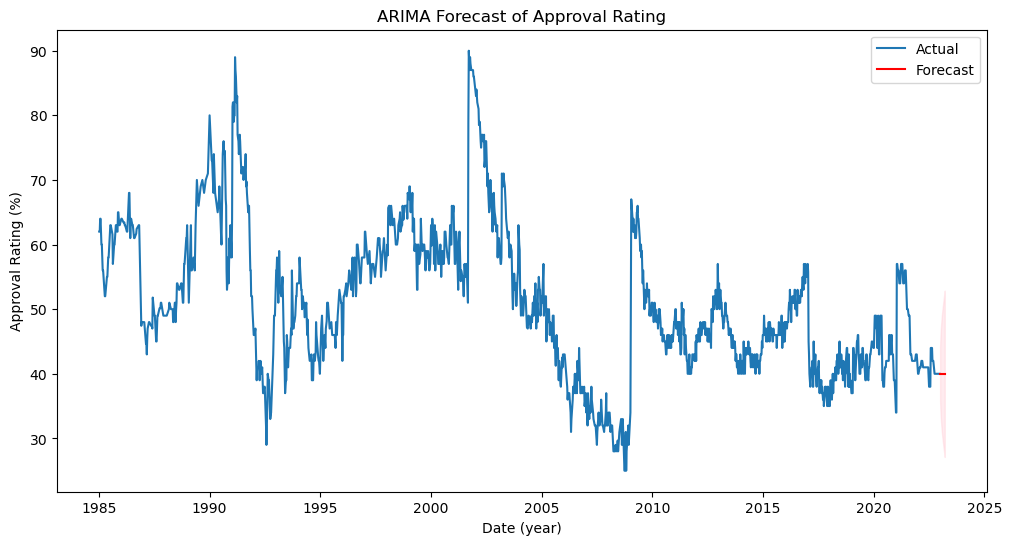

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# define model (can change p, d, q)
model = ARIMA(merged_df['Approval_Rating'], order=(5,1,0)) # Example order, can be tuned
results = model.fit()

# forecast for next 12 weeks
forecast = results.get_forecast(steps=12)
conf_int = forecast.conf_int()

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['Approval_Rating'], label='Actual')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date (year)')
plt.ylabel('Approval Rating (%)') 
plt.legend()
plt.title('ARIMA Forecast of Approval Rating')
plt.show()


Mean of residuals: 0.0185


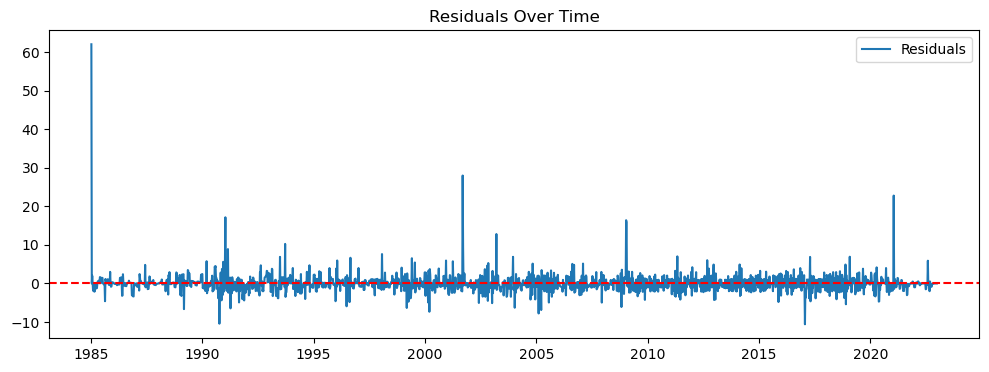

In [8]:
#residuals = difference between actual and predicted values
residuals = results.resid
print(f"Mean of residuals: {residuals.mean():.4f}")

#plot to check for bias or patterns
plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

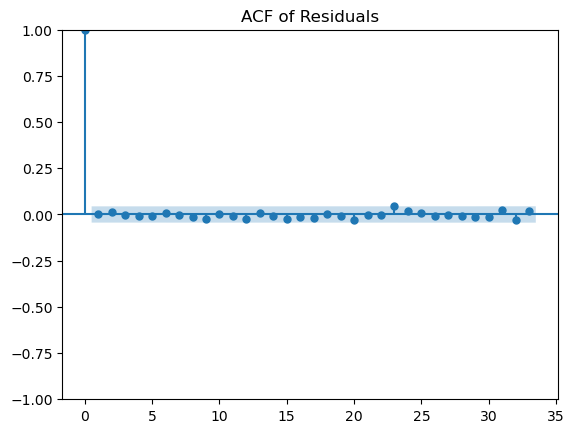

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

#autocorrelation function of residuals
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()


13:31:27 - cmdstanpy - INFO - Chain [1] start processing
13:31:30 - cmdstanpy - INFO - Chain [1] done processing


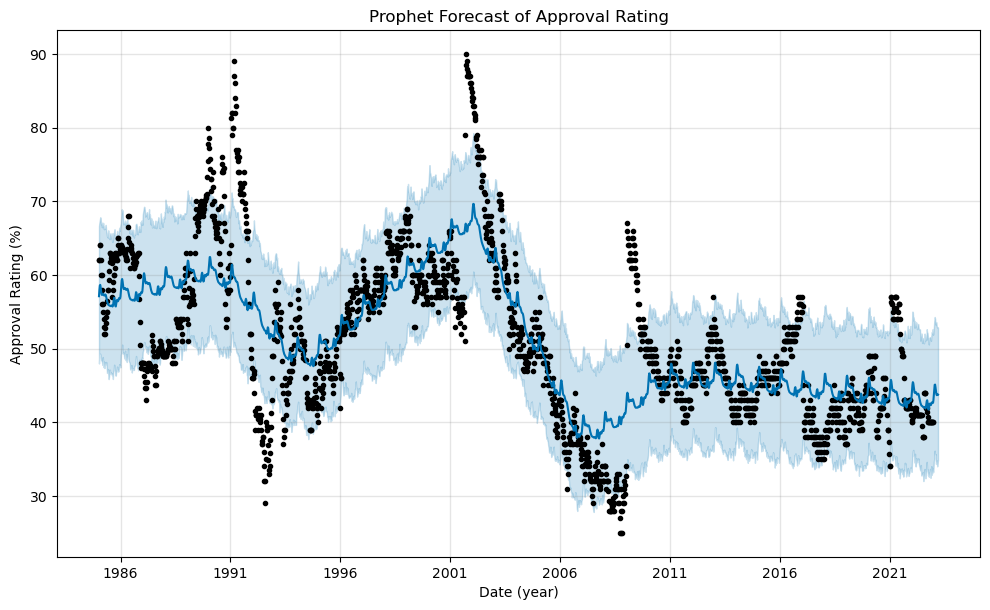

In [11]:
#also used prophet
from prophet import Prophet

prophet_df = merged_df[['Approval_Rating']].reset_index()
prophet_df.columns = ['ds', 'y']

#fit model
prophet = Prophet()
prophet.fit(prophet_df)

# future forecast
future = prophet.make_future_dataframe(periods=12, freq='W')
forecast = prophet.predict(future)

# plot
fig = prophet.plot(forecast)
plt.title('Prophet Forecast of Approval Rating')
plt.xlabel('Date (year)')
plt.ylabel('Approval Rating (%)') 
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

# use last 12 weeks as test set
test = merged_df['Approval_Rating'][-12:]
predictions = forecast['yhat'][-12:]
#rmse
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.2f}')


RMSE: 4.14


In [ ]:
# align prediction index to match test set dates
predictions.index = test.index
test, predictions = test.align(predictions, join='inner')

# calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, predictions)

print(f'MAPE: {mape:.2f}%')

MAPE: 10.24%


In [14]:
print(test)
print(predictions)

2022-10-10    40.0
2022-10-17    40.0
2022-10-24    40.0
2022-10-31    40.0
2022-11-07    40.0
2022-11-14    40.0
2022-11-21    40.0
2022-11-28    40.0
2022-12-05    40.0
2022-12-12    40.0
2022-12-19    40.0
2022-12-26    40.0
Freq: W-MON, Name: Approval_Rating, dtype: float64
2022-10-10    42.980371
2022-10-17    43.714696
2022-10-24    44.543961
2022-10-31    45.081442
2022-11-07    45.115039
2022-11-14    44.728252
2022-11-21    44.203179
2022-11-28    43.816321
2022-12-05    43.682520
2022-12-12    43.730574
2022-12-19    43.796814
2022-12-26    43.760021
Freq: W-MON, Name: yhat, dtype: float64
